## Probelm Statement:

To build a classification model using word embeddings to classify email messages as Spam or Ham.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/word2vec-google/GoogleNews-vectors-negative300.bin
/kaggle/input/spam-text-message-classification/SPAM text message 20170820 - Data.csv


## Import Required Libraries:

In [25]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models import KeyedVectors
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding
from warnings import filterwarnings
filterwarnings('ignore')

## Loading the data:

In [3]:
data_spam=pd.read_csv("../input/spam-text-message-classification/SPAM text message 20170820 - Data.csv")
data_spam.head(10)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [4]:
# Replace Spam with 1 and Ham with 0
data_spam['Category']=data_spam['Category'].replace({'ham':0,'spam':1})
data_spam.head()

,Category,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
data_spam.shape    # 5572 rows and 2 columns available

(5572, 2)

## Text Pre-processing:

In [6]:
# Original sentence before text pre-processing
data_spam['Message'][2]

"Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"

In [7]:
stop_words=stopwords.words('english')
lemma=WordNetLemmatizer()

sentence=data_spam['Message']

new_sentence=[]
for i in range(len(sentence)):
    
    # excluding the irrelavent characters
    word=re.sub("[^a-zA-Z\.\!]"," ",sentence[i])
    
    #Lower casing all words
    word=word.lower()
    
    #Splitting each sentence into words
    word=word.split()
    
    #Performing lemmatization to retain the root word out of all the inflected words. Also eliminating stopwords
    word=[lemma.lemmatize(w) for w in word if w not in stop_words]
    word=" ".join(word)
    new_sentence.append(word)

#Sentence after pre-processing
new_sentence[2]

'free entry wkly comp win fa cup final tkts st may . text fa receive entry question std txt rate c apply'

In [8]:
data_spam['New_Message']=new_sentence
data_spam.head()

,Category,Message,New_Message
0,0,"Go until jurong point, crazy.. Available only ...",go jurong point crazy.. available bugis n grea...
1,0,Ok lar... Joking wif u oni...,ok lar... joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts st ...
3,0,U dun say so early hor... U c already then say...,u dun say early hor... u c already say...
4,0,"Nah I don't think he goes to usf, he lives aro...",nah think go usf life around though


## Building a Word Embedding Matrix:

In [10]:
# Loading a pre-trained word2vec model 
embeddings=KeyedVectors.load_word2vec_format('../input/word2vec-google/GoogleNews-vectors-negative300.bin',binary=True)


In [11]:
# Splitting data into train and test
train_X,test_X,train_y,test_y=train_test_split(data_spam['New_Message'],data_spam['Category'],test_size=0.3,random_state=10)

In [12]:
# Initialising the Tokenizer
tokenizer=Tokenizer()

# Fitting the tokenizer on train_x
tokenizer.fit_on_texts(train_X)

# Number of words 
vocab_size=len(tokenizer.word_index)+1

#Converting the words to sequence of their corresponding index
train_X_seq=tokenizer.texts_to_sequences(train_X)
test_X_seq=tokenizer.texts_to_sequences(test_X)

Length of First 10 sequence: [17, 2, 4, 4, 21, 6, 21, 5, 9, 18]
Maximum length of sequence: 97


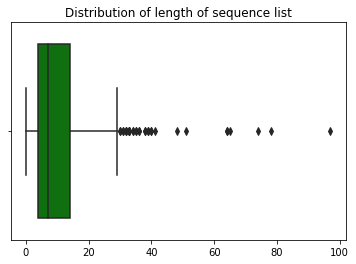

In [13]:

#Obtaining the length of each sequence list inoder to find the maximum length which is to be used for padding the train and test
len_doc=[]
for doc in train_X_seq:
    doc_size=len(doc)
    len_doc.append(doc_size)

print("Length of First 10 sequence:",len_doc[:10])
print("Maximum length of sequence:",max(len_doc))

sns.boxplot(len_doc,color='green')
plt.title("Distribution of length of sequence list")
plt.show()

In [14]:
#Padding each list of sequence to ensure each of them have same dimension.Considering max length as 97

train_X_pad=pad_sequences(train_X_seq,maxlen=97,padding='post')
test_X_pad=pad_sequences(test_X_seq,maxlen=97,padding='post')

In [20]:
# Building the weight matrix 
embeddings_mat=np.zeros((vocab_size,300))
words_available=[]
words_not_available=[]

for w,wid in tokenizer.word_index.items():
    if w in embeddings:
        embeddings_mat[wid]=embeddings[w]
        words_available.append(w)
        
    else:
        words_not_available.append(w)

In [24]:
# Amount of words not available in the pre-trained embeddings model
len(words_not_available)/vocab_size *100

18.51126346718903

## Building a Classification model:

In [27]:
# Initialising the model
model=Sequential()

# Since we already have the weights matrix, there is not need to further train the weights and hence setting trainable parameter as False
model.add(Embedding(vocab_size,300,weights=[embeddings_mat],input_length=97,trainable=False))

# Flattening the layers
model.add(Dense(units=16,activation='relu'))

#Output Layer
model.add(Dense(units=1,activation='sigmoid'))

## Compiling the model:

In [28]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

## Fitting the model on Train data:

In [31]:
my_model=model.fit(x=train_X_pad,y=train_y,batch_size=32,epochs=50,validation_data=(test_X_pad,test_y))

Epoch 1/50
122/122 [==============================] - 1s 7ms/step - loss: 0.3750 - accuracy: 0.8731 - val_loss: 0.3653 - val_accuracy: 0.8781
Epoch 2/50
122/122 [==============================] - 1s 6ms/step - loss: 0.3745 - accuracy: 0.8732 - val_loss: 0.3647 - val_accuracy: 0.8784
Epoch 3/50
122/122 [==============================] - 1s 7ms/step - loss: 0.3743 - accuracy: 0.8732 - val_loss: 0.3644 - val_accuracy: 0.8784
Epoch 4/50
122/122 [==============================] - 1s 8ms/step - loss: 0.3743 - accuracy: 0.8732 - val_loss: 0.3644 - val_accuracy: 0.8784
Epoch 5/50
122/122 [==============================] - 1s 8ms/step - loss: 0.3743 - accuracy: 0.8733 - val_loss: 0.3643 - val_accuracy: 0.8783
Epoch 6/50
122/122 [==============================] - 1s 7ms/step - loss: 0.3741 - accuracy: 0.8733 - val_loss: 0.3643 - val_accuracy: 0.8784
Epoch 7/50
122/122 [==============================] - 1s 6ms/step - loss: 0.3740 - accuracy: 0.8733 - val_loss: 0.3642 - val_accuracy: 0.8783
Epoch 

## Comparing Performance:

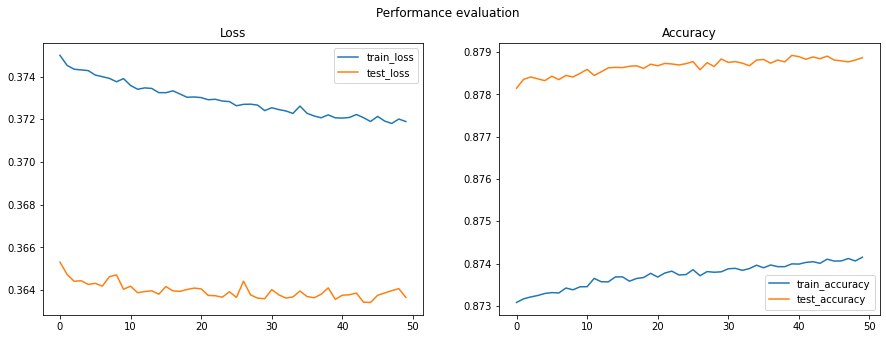

In [59]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(my_model.history['loss'],label='train_loss')
plt.plot(my_model.history['val_loss'],label='test_loss')
plt.title("Loss")
plt.legend()
plt.suptitle("Performance evaluation")

plt.subplot(122)
plt.plot(my_model.history['accuracy'],label='train_accuracy')
plt.plot(my_model.history['val_accuracy'],label='test_accuracy')
plt.title("Accuracy")
plt.legend()
plt.show()

## Conclusion:

- A spam classifier was built using  a pre-trained word embedding model

- The model gave an accuracy of 87.4% on Train data and 87.8% on Test data.

- The model gave a binaray cross-entropy loss of 0.37 on Train data and 0.36 on test data.

- As per the scores, the model built exhibited exceptionally low over-fitting.